# Spectral Partitioning of Bipartite Graphs

---

Typical example of bipartite graph is a graph obtained from a collection of documents presented as a _term $\times$ document_  matrix.

## Prerequisites

The reader should be familiar with k-means algorithm and spectral graph partitioning theory and algorithms.
 
## Competences 

The reader should be able to apply spectral partitioning of bipartite graphs to data clustering problems.

__Credits__: The notebook is based on [I. Mirošević, Spectral Graph Partitioning and Application to Knowledge Extraction][Mir05].

[Mir05]: #1 "I. Mirošević, 'Spectral Graph Partitioning and Application to Knowledge Extraction', M.Sc. Thesis, Iniversity of Zagreb, 2005 (in Croatian)." 

---

## Definitions

__Undirected bipartite graph__ $G$ is a triplet 
$G=(T,D,E)$, where $T=\{t_{1},\cdots ,t_{m}\}$ and 
$D=\{d_{1},...,d_{n}\}$ are two sets of vertices and
$E=\{(t_{i},d_{j}):t_{i}\in R,d_{j}\in D\}$, 
is a set of edges.

$G$ is __weighted__ if there is weight $\omega(e)$ associated with each edge $e\in E$.

For example, $D$ is a set of documents, 
$T$ is a set of terms (words) and  edge $e=(t_{i},d_{j})$ exists if
document $d_{j}$ contains term $t_{i}$. Weight $\omega(e)$ can be number of appearances 
of the term $t_i$ in the document $d_j$.

A __term-by-document-matrix__ is a matrix $A\in\mathbb{R}^{m\times n}$ with 
$A_{ij}=\omega((t_i,d_j))$.

## Facts

1. The weight matrix of $G$ is $W=\begin{bmatrix}0 & A \\ A^{T} & 0 \end{bmatrix}$.

2. The Laplacian matrix of $G$ is 
$L=\begin{bmatrix} \Delta_{1} & -A \\ -A^{T} & \Delta_{2}\end{bmatrix}$,
where $\Delta_1$ and $\Delta_2$ are diagonal matrices with elements 
$\Delta_{1,ii}=\sum\limits_{j=1}^n A_{ij}$ for $i=1,\ldots,m$, and 
$\Delta_{1,jj}=\sum\limits_{i=1}^m A_{ij}$ for $j=1,\ldots,n$.

3. The normalized Laplacian matrix of $G$ is 
$L_n=\begin{bmatrix}
I & -\Delta_{1}^{-\frac{1}{2}}A\Delta_{2}^{-\frac{1}{2}} \\
-\Delta_{2}^{-\frac{1}{2}}A^T\Delta_{1}^{-\frac{1}{2}} & I
\end{bmatrix} \equiv 
\begin{bmatrix} I & -A_n \\ -A_n^T & I \end{bmatrix}$.

4. Let $\lambda$ be an eigenvalue of $L_n$ with an eigenvector 
$w=\begin{bmatrix} u \\ v\end{bmatrix}$, where 
$u\in \mathbb{R}^{m}$ $v\in\mathbb{R}^{n}$.
Then $L_n w=\lambda w$ implies
$A_n v =(1-\lambda)u$ and $A_n^T u=(1-\lambda)v$. Vice versa, if $(u,\sigma,v)$ is a singular triplet of $A_n$, then $1-\sigma$ is an eigenvalue of $L_n$ with (non-unit) eigenvector $w=\begin{bmatrix} u \\ v\end{bmatrix}$. 

5. The second largest singular value of $A_n$ corresponds to the second smallest eigenvalue of $L_n$, and computing the former is numerically more stable. 

5. _Bipartitioning algorithm_ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute singular vectors of $A_{n}$, $u^{[2]}$ and $v^{[2]}$, which correspond to 
    the second largest singular value, $\sigma_2(A_n)$.
    3. Assign the partitions $T=\{T_1,T_2\}$ and $D=\{D_1,D_2\}$ according to the signs of 
    $u^{[2]}$ and $v^{[2]}$. The pair $(T,D)$ is now partitioned as 
    $\{(T_1,D_1),(T_2,D_2)\}$.


6. _Recursive bipartitioning algorithm_ is the following:
    1. Compute the bipartition $\pi=\{(T_1,D_1),(T_2,D_2)\}$ of 
    $(T,D)$. Set the counter $c=2$.
    2. While $c<k$ repeat
         1. compute bipartitions of each of the subpartitions of $(T,D)$,
         2. among all $(c+1)$-subpartitions, choose the one with the smallest 
         $pcut(\pi_{c+1})$ or $ncut(\pi_{c+1})$, respectively.
    3. Set $c=c+1$
    3. Stop

7. _Multipartitioning algorithm_ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute $k$ left and right singular vectors, $u^{[1]},\ldots,u^{[k]}$ and 
    $v^{[1]},\ldots,v^{[k]}$, which correspond to $k$ largest singular values 
    $\sigma_1\geq \cdots \geq \sigma_k$ of $A_n$.
    3. Partition the rows of matrices 
    $\Delta_{1}^{-\frac{1}{2}}\begin{bmatrix} u^{[1]} & \ldots & u^{[k]}\end{bmatrix}$
    and 
    $\Delta_{2}^{-\frac{1}{2}}\begin{bmatrix} v^{[1]} & \ldots & v^{[k]}\end{bmatrix}$
    with the k-means algorithm.

### Example - Small term-by- document matrix

In [1]:
using Graphs
using IJuliaPortrayals
using Clustering

  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:51
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:51
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:61
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:61
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:81
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:81
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:97
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:97
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:108
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:108
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortrayals.jl:119
  likely near C:\Users\Ivan\.julia\v0.5\IJuliaPortrayals\src\IJuliaPortra

In [2]:
# Sources, targets, and weight
dn=[6,6,6,7,7,7]
tn=[1,2,3,2,4,5]
wn=[3,1,2,3,2,3]
[dn tn wn]

6×3 Array{Int64,2}:
 6  1  3
 6  2  1
 6  3  2
 7  2  3
 7  4  2
 7  5  3

In [3]:
G = inclist(ExVertex, ExEdge{ExVertex}; is_directed=false)
for i=1:5
    add_vertex!(G, ExVertex(i,"$i"))
    attrs=attributes(G.vertices[i],G)
    attrs["label"]="Term $i"
end

for i=1:2
    add_vertex!(G, ExVertex(i+5,"$(i+5)"))
    attrs=attributes(G.vertices[i+5],G)
    attrs["label"]="Document $i"
end

for i=1:6
    add_edge!(G, vertices(G)[dn[i]], vertices(G)[tn[i]])
end
for i=1:length(G.inclist)
    for j=1:length(G.inclist[i])
        ei=G.inclist[i][j]
        attrs = attributes(ei, G)
        attrs["label"] = wn[edge_index(ei,G)]
    end
end

In [5]:
# Plot
GraphViz(to_dot(G),"fdp","svg")

IJuliaPortrayals.GraphViz("graph graphname {\n1 [\"label\"=\"Term 1\"]\n1 -- 6 [\"label\"=\"3\"]\n2 [\"label\"=\"Term 2\"]\n2 -- 6 [\"label\"=\"1\"]\n2 -- 7 [\"label\"=\"3\"]\n3 [\"label\"=\"Term 3\"]\n3 -- 6 [\"label\"=\"2\"]\n4 [\"label\"=\"Term 4\"]\n4 -- 7 [\"label\"=\"2\"]\n5 [\"label\"=\"Term 5\"]\n5 -- 7 [\"label\"=\"3\"]\n6 [\"label\"=\"Document 1\"]\n7 [\"label\"=\"Document 2\"]\n}\n","fdp","svg")

In [6]:
W=weight_matrix(G,wn)

7×7 Array{Int64,2}:
 0  0  0  0  0  3  0
 0  0  0  0  0  1  3
 0  0  0  0  0  2  0
 0  0  0  0  0  0  2
 0  0  0  0  0  0  3
 3  1  2  0  0  0  0
 0  3  0  2  3  0  0

In [7]:
A=W[1:5,6:7]
Δ1=sqrt(sum(A,2))
Δ2=sqrt(sum(A,1))
An=map(Float64,[A[i,j]/(Δ1[i]*Δ2[j]) for i=1:size(A,1), j=1:size(A,2)])

5×2 Array{Float64,2}:
 0.707107  0.0     
 0.204124  0.53033 
 0.57735   0.0     
 0.0       0.5     
 0.0       0.612372

In [8]:
# The partitioning - explain the results!
U,σ,V=svd(An)

(
[-0.46291 0.604743; -0.534522 -0.218218; … ; -0.377964 -0.370328; -0.46291 -0.453557],

[1.0,0.883883],
[-0.654654 0.755929; -0.755929 -0.654654])

In [9]:
U[:,2]

5-element Array{Float64,1}:
  0.604743
 -0.218218
  0.493771
 -0.370328
 -0.453557

In [10]:
V[:,2]

2-element Array{Float64,1}:
  0.755929
 -0.654654

### Example - Sets of points

In [11]:
using Gadfly
using Images

In [12]:
?sprand

search: sprand sprandn sprandbool StepRange sparse2adjacencylist



```
sprand([rng],[type],m,[n],p::AbstractFloat,[rfn])
```

Create a random length `m` sparse vector or `m` by `n` sparse matrix, in which the probability of any element being nonzero is independently given by `p` (and hence the mean density of nonzeros is also exactly `p`). Nonzero values are sampled from the distribution specified by `rfn` and have the type `type`. The uniform distribution is used in case `rfn` is not specified. The optional `rng` argument specifies a random number generator, see [Random Numbers](:ref:`Random Numbers <random-numbers>`).


In [16]:
# Define sizes
m=[200,100,100]
n=[100,200,100]
density=[0.5,0.7,0.4]
A=Array(Any,3)
for i=1:3
    A[i]=sprand(m[i],n[i],density[i])
end
B=blkdiag(A[1],A[2],A[3])

400×400 sparse matrix with 27959 Float64 nonzero entries:
	[5  ,   1]  =  0.184587
	[6  ,   1]  =  0.218685
	[10 ,   1]  =  0.785835
	[11 ,   1]  =  0.831322
	[12 ,   1]  =  0.151954
	[13 ,   1]  =  0.332985
	[15 ,   1]  =  0.872084
	[16 ,   1]  =  0.128925
	[18 ,   1]  =  0.260016
	[21 ,   1]  =  0.731407
	⋮
	[377, 400]  =  0.022299
	[378, 400]  =  0.0221014
	[380, 400]  =  0.0809118
	[381, 400]  =  0.108487
	[382, 400]  =  0.820347
	[384, 400]  =  0.0873474
	[386, 400]  =  0.533827
	[388, 400]  =  0.558838
	[391, 400]  =  0.772806
	[392, 400]  =  0.0722203
	[395, 400]  =  0.014694

In [18]:
pB=spy(B)
draw(Gadfly.PNG("pB.png", 4inch, 4inch), pB)

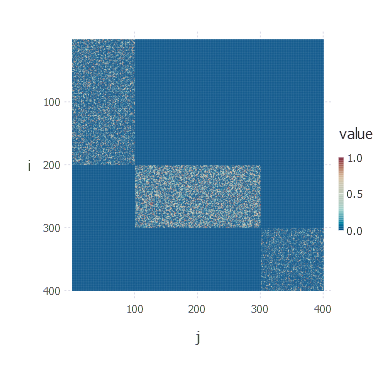

In [20]:
load("pB.png")

In [21]:
# The structure of singular vectors reflects the blocks
S,rest=svds(B,nsv=3)

(Base.LinAlg.SVD{Float64,Float64,Array{Float64,2}}([5.09418e-17 -0.0756864 -2.80984e-17; 3.32735e-17 -0.0681254 -6.27895e-17; … ; 5.15564e-18 1.68427e-17 0.122118; -7.11495e-19 7.44854e-18 0.0794925],[49.1094,36.3487,20.1527],[5.24317e-17 -0.0776827 -3.46907e-17; 8.65995e-17 -0.108387 -4.33256e-17; … ; 1.00449e-18 -3.5751e-18 0.0986961; -5.84453e-19 -3.37041e-18 0.0999965]),6,2,34,[-0.106788,-0.0464237,0.266718,0.166095,-0.0618726,0.100684,-0.106071,0.0358928,-0.109251,0.0423501  …  -0.159705,0.196088,0.119458,0.217943,0.121481,-0.0150752,-0.163161,0.0736919,-0.155756,0.165458])

In [18]:
# S is a structure
fieldnames(S)

3-element Array{Symbol,1}:
 :U 
 :S 
 :Vt

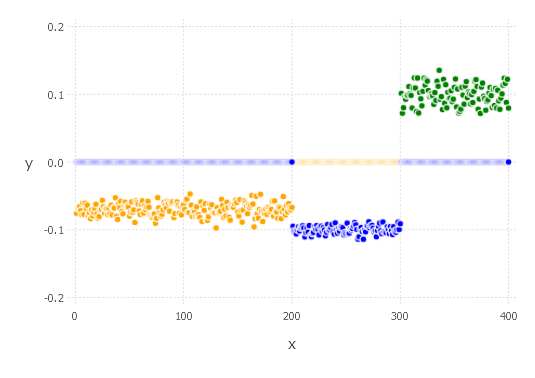

In [22]:
# Plot the first three left singular vectors
k=size(B,1)
x=collect(1:k)
Gadfly.plot(layer(x=x,y=S.U[:,1],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=S.U[:,2], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=S.U[:,3], Geom.point,Theme(default_color=colorant"green")))

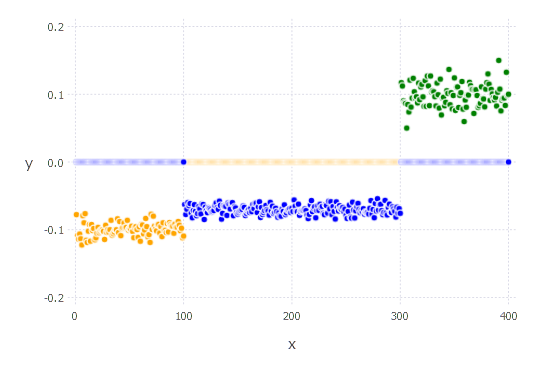

In [23]:
# Plot the first three right singular vectors
Gadfly.plot(layer(x=x,y=S.Vt[:,1],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=S.Vt[:,2], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=S.Vt[:,3], Geom.point,Theme(default_color=colorant"green")))

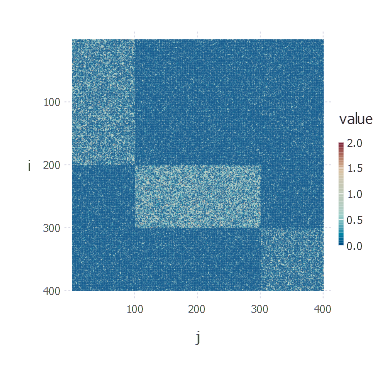

In [25]:
# Add random noise
noise=sprand(k,k,0.3)
C=B+noise
pC=spy(C)
draw(Gadfly.PNG("pC.png", 4inch, 4inch), pC)
load("pC.png")

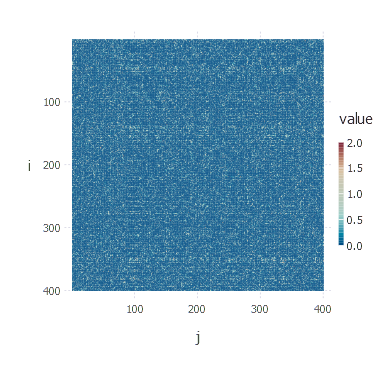

In [26]:
# Apply random permutation to rows and columns of C
D=C[randperm(k),randperm(k)]
pD=spy(D)
draw(Gadfly.PNG("pD.png", 4inch, 4inch), pD)
load("pD.png")

In [27]:
# Given D, we can recover C with spectral partitioning!!
S,rest=svds(D,nsv=3)

(Base.LinAlg.SVD{Float64,Float64,Array{Float64,2}}([0.0414136 -0.0388822 0.0178427; 0.0452719 -0.029939 0.0185637; … ; 0.0400862 -0.00547947 -0.106551; 0.0448185 -0.0406703 0.0391708],[98.4293,42.8829,25.1301],[0.0345413 -0.0269343 -0.0688912; 0.0537758 -0.0650296 0.049007; … ; 0.046077 -0.0624275 0.0396451; 0.0496755 0.04625 0.0233843]),6,3,42,[0.51009,0.124393,0.0464343,0.424511,0.122092,0.204828,-0.114835,-0.127912,-0.106754,-0.114606  …  -0.398784,0.0801844,-0.106301,-0.230508,0.0275443,0.166219,-0.063919,0.315704,0.0155238,0.326588])

In [28]:
# Kmeans on rows and U and V
using Clustering

In [29]:
outU=kmeans((S.U)',3)

Clustering.KmeansResult{Float64}([0.038271 0.0440182 0.0679298; -0.0126173 -0.0483368 0.0700169; -0.0879965 0.0242618 0.0182261],[2,2,3,3,1,3,2,2,1,1  …  2,1,3,3,1,2,1,2,1,2],[0.000137378,0.00037252,0.000148073,0.000228371,0.000160881,6.09413e-5,6.60381e-5,0.000509154,0.000189371,0.000583492  …  6.41756e-5,5.30562e-5,9.99348e-5,0.000440499,0.000655681,0.000169852,0.000193078,0.000141584,0.000398525,0.000281695],[100,200,100],[100.0,200.0,100.0],0.10583708750682347,3,true)

In [30]:
outV=kmeans((S.Vt)',3)

Clustering.KmeansResult{Float64}([0.0536678 0.0376995 0.0525779; 0.0435772 -0.0207333 -0.0741456; 0.011603 -0.0862683 0.0382935],[2,3,2,3,1,2,1,3,1,2  …  1,2,2,1,2,3,1,1,3,1],[0.00035039,0.000199317,0.00099128,0.000267457,0.000421375,0.000215626,0.000148524,4.09062e-5,0.000251247,0.000429691  …  0.000119152,0.000874581,0.000182937,0.000604847,0.000249769,0.000207543,3.50563e-5,1.0007e-5,0.000181402,0.000161882],[200,100,100],[200.0,100.0,100.0],0.1150585324565374,2,true)

In [31]:
sortperm(outV.assignments)

400-element Array{Int64,1}:
   5
   7
   9
  11
  14
  17
  21
  24
  25
  26
  28
  31
  32
   ⋮
 369
 374
 377
 378
 380
 382
 383
 385
 389
 390
 396
 399

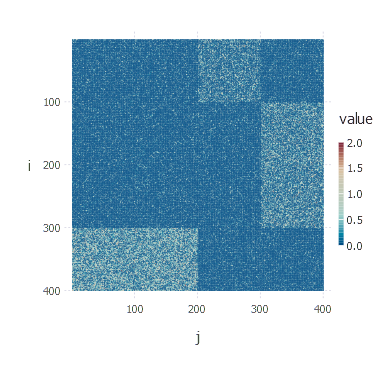

In [32]:
E=D[sortperm(outU.assignments),sortperm(outV.assignments)]
pE=spy(E)
draw(Gadfly.PNG("pE.png", 4inch, 4inch), pE)
load("pE.png")